In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string


df = pd.read_csv('top_10000_popular_movies_tmdb.csv')

The average length of the overviews is 272.23 characters.


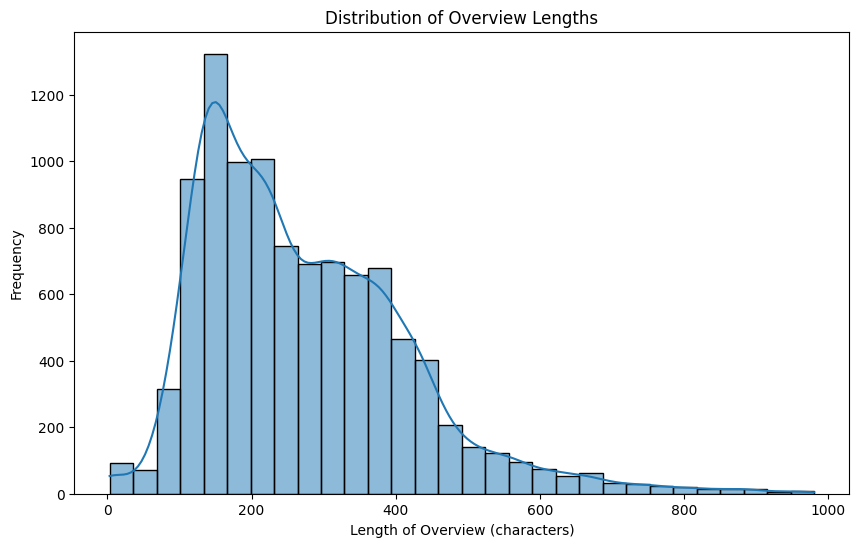

In [11]:
# Calculate the lengths of the overviews
df['overview_length'] = df['overview'].str.len()

#ethan's code
average_length = df['overview_length'].mean()
print(f"The average length of the overviews is {average_length:.2f} characters.")

# Plot the histogram and density plot
plt.figure(figsize=(10, 6))
sns.histplot(df['overview_length'], kde=True, bins=30)
plt.title('Distribution of Overview Lengths')
plt.xlabel('Length of Overview (characters)')
plt.ylabel('Frequency')
plt.show()

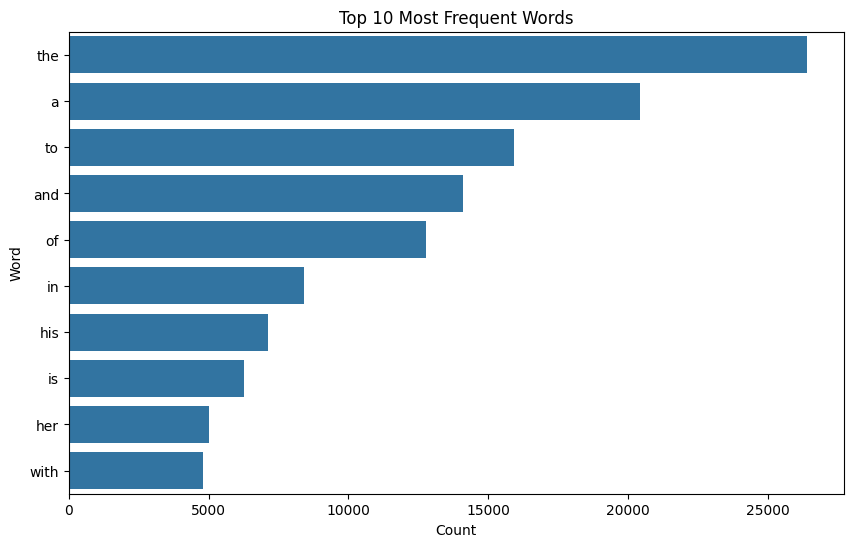

In [ ]:
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

# Load the dataset
df = pd.read_csv('top_10000_popular_movies_tmdb.csv')

# Remove punctuation and make all characters lowercase
df['overview'] = df['overview'].apply(lambda x: ''.join([char for char in str(x) if char not in string.punctuation]).lower())

# Tokenize the text into words
df['tokens'] = df['overview'].str.split()

# Count the frequency of each word
word_counts = df['tokens'].explode().value_counts()

stop_words = set(stopwords.words('english'))

df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

# Count the frequency of each word again after removing stopwords
word_counts_no_stopwords = df['tokens'].explode().value_counts()

# Get the top 10 most frequent words and This converts the Series into a DataFrame
# top_10_df = word_counts.head(10).reset_index()
top_10_df = word_counts_no_stopwords.head(10).reset_index()
top_10_df.columns = ['word', 'count']

# Plot the top 10 words using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='word', data=top_10_df)
plt.title('Top 10 Most Frequent Words (no stopwords)')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()
